In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

In [60]:
intraday_data = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/fandi_intraday_data.csv')
daily_data = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/fandi_daily.csv', parse_dates=['DATE'])

In [61]:
intraday_data['datetime'] = intraday_data['date'] + ' ' + intraday_data['time']
intraday_data['datetime'] = pd.to_datetime(intraday_data['datetime'])
intraday_data['date'] = pd.to_datetime(intraday_data['date'])

intraday_data['symbol'] = intraday_data['sym_root'] + intraday_data['sym_suffix']
intraday_data.loc[intraday_data['sym_suffix'].isnull(), 'symbol'] = intraday_data['sym_root']

sym_vol = {}

intra = intraday_data.loc[intraday_data['symbol'] == 'GOOG']
daily = daily_data.loc[daily_data['symbol'] == 'GOOG']
df = intra.merge(daily[['DATE', 'symbol', 'total_vol_m']], how='left', left_on=['date', 'symbol'], right_on = ['DATE', 'symbol'])
df.index = pd.DatetimeIndex(df['datetime'])
df.drop(columns=['DATE','datetime'], inplace=True)
df = df.between_time('09:30:00', '16:00:00')
df['%_vol'] = df['size']/df['total_vol_m']
sym_vol['GOOG'] = df

In [62]:
df.head()

,date,time,sym_root,sym_suffix,size,symbol,total_vol_m,%_vol
datetime,,,,,,,,
2019-01-02 09:30:00,2019-01-02,09:30:00,GOOG,NaN,54459.0,GOOG,1360775.0,0.040021
2019-01-02 09:31:00,2019-01-02,09:31:00,GOOG,NaN,8591.0,GOOG,1360775.0,0.006313
2019-01-02 09:32:00,2019-01-02,09:32:00,GOOG,NaN,9315.0,GOOG,1360775.0,0.006845
2019-01-02 09:33:00,2019-01-02,09:33:00,GOOG,NaN,4833.0,GOOG,1360775.0,0.003552
2019-01-02 09:34:00,2019-01-02,09:34:00,GOOG,NaN,5542.0,GOOG,1360775.0,0.004073


In [ ]:
#df = pd.read_csv('AAPL_merged_data.csv',index=False)

In [63]:
def generate_u_curve(data):
    '''Generate u_curve based on 180 day average intraday volume'''

    # groupby time to calculate 180-day rolling average volume
    df = data.groupby(data.index.time)['%_vol'].rolling(180).mean()

    # ungroup, then sort df by date and time
    df = df.reset_index()
    df.rename(columns={'level_0': 'time', '%_vol': 'avg_%_vol'}, inplace=True)
    df['date'] = df['datetime'].dt.date
    df = df.sort_values(['date', 'time'], ascending=(True, True)).set_index(['date', 'time'])
    df.drop(columns=['datetime'], inplace=True)

    # convert date from row index to column index
    df = df.unstack().transpose()
    df.index = df.index.droplevel(0)

    return df

In [64]:
df = generate_u_curve(df)
df

date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,...,2021-12-16,2021-12-17,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
time,,,,,,,,,,,,,,,,,,,,,
09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045268,0.046143,0.046091,0.046039,0.045965,0.046042,0.045988,0.045979,0.046214,0.046260
09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006669,0.006641,0.006582,0.006583,0.006529,0.006530,0.006455,0.006418,0.006410,0.006421
09:32:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005922,0.005895,0.005868,0.005796,0.005787,0.005796,0.005797,0.005788,0.005781,0.005801
09:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005596,0.005579,0.005573,0.005493,0.005442,0.005448,0.005433,0.005425,0.005426,0.005423
09:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005561,0.005548,0.005522,0.005506,0.005473,0.005470,0.005475,0.005476,0.005468,0.005442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.008983,0.008968,0.008994,0.008991,0.008996,0.008942,0.008923,0.008899,0.008916,0.008946
15:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009910,0.009884,0.009924,0.009921,0.009936,0.009930,0.009879,0.009876,0.009903,0.009914
15:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011759,0.011745,0.011777,0.011842,0.011816,0.011810,0.011806,0.011806,0.011833,0.011950


In [65]:
df = df.dropna(axis=1)

In [66]:
#df['avrg'] = df.mean(axis = 1)
#df

In [67]:
df

date,2019-09-19,2019-09-20,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-30,2019-10-01,2019-10-02,...,2021-12-16,2021-12-17,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
time,,,,,,,,,,,,,,,,,,,,,
09:30:00,0.048938,0.050882,0.050926,0.050857,0.050873,0.050883,0.050895,0.051121,0.051203,0.051298,...,0.045268,0.046143,0.046091,0.046039,0.045965,0.046042,0.045988,0.045979,0.046214,0.046260
09:31:00,0.006478,0.006409,0.006423,0.006425,0.006412,0.006398,0.006409,0.006411,0.006409,0.006413,...,0.006669,0.006641,0.006582,0.006583,0.006529,0.006530,0.006455,0.006418,0.006410,0.006421
09:32:00,0.005396,0.005391,0.005403,0.005393,0.005387,0.005388,0.005393,0.005413,0.005471,0.005483,...,0.005922,0.005895,0.005868,0.005796,0.005787,0.005796,0.005797,0.005788,0.005781,0.005801
09:33:00,0.005088,0.005093,0.005088,0.005086,0.005107,0.005122,0.005100,0.005091,0.005117,0.005122,...,0.005596,0.005579,0.005573,0.005493,0.005442,0.005448,0.005433,0.005425,0.005426,0.005423
09:34:00,0.005059,0.005065,0.005075,0.005079,0.005094,0.005118,0.005132,0.005110,0.005107,0.005121,...,0.005561,0.005548,0.005522,0.005506,0.005473,0.005470,0.005475,0.005476,0.005468,0.005442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15:56:00,0.007985,0.007971,0.007986,0.007975,0.007974,0.007965,0.007924,0.007933,0.007931,0.007920,...,0.008983,0.008968,0.008994,0.008991,0.008996,0.008942,0.008923,0.008899,0.008916,0.008946
15:57:00,0.008330,0.008299,0.008302,0.008277,0.008283,0.008274,0.008271,0.008278,0.008265,0.008263,...,0.009910,0.009884,0.009924,0.009921,0.009936,0.009930,0.009879,0.009876,0.009903,0.009914
15:58:00,0.011625,0.011614,0.011582,0.011554,0.011490,0.011470,0.011451,0.011480,0.011464,0.011448,...,0.011759,0.011745,0.011777,0.011842,0.011816,0.011810,0.011806,0.011806,0.011833,0.011950


In [68]:
new_data = df.stack().reset_index(-1, drop=True)
new_data

time
09:30:00    0.048938
09:30:00    0.050882
09:30:00    0.050926
09:30:00    0.050857
09:30:00    0.050873
              ...   
16:00:00    0.229486
16:00:00    0.229236
16:00:00    0.229080
16:00:00    0.228397
16:00:00    0.229341
Length: 151708, dtype: float64

In [69]:
new_data.values

array([0.0489382 , 0.05088159, 0.05092649, ..., 0.22907978, 0.22839689,
       0.2293412 ])

In [100]:
new_data.index

Index([09:30:00, 09:30:00, 09:30:00, 09:30:00, 09:30:00, 09:30:00, 09:30:00,
       09:30:00, 09:30:00, 09:30:00,
       ...
       16:00:00, 16:00:00, 16:00:00, 16:00:00, 16:00:00, 16:00:00, 16:00:00,
       16:00:00, 16:00:00, 16:00:00],
      dtype='object', name='time', length=151708)

In [90]:
n = 388 * 60
n 

23280

In [92]:
x_i = np.linspace(391, 23280, 22889)
len(x_i)

22889

In [91]:
len(y_i)

22889

t: [  391.   391.   391.   391.   391.   391. 23280. 23280. 23280. 23280.
 23280. 23280.]
c: [0.00629592 0.00228246 0.00519971 0.00150614 0.00298717 0.0023524
 0.         0.         0.         0.         0.         0.        ]
k: 5



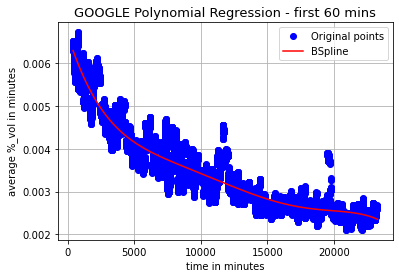

<Figure size 2160x1440 with 0 Axes>

In [93]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

y_i = new_data.values[391:n]
x_i = np.linspace(391, 23280, 22889)
t, c, k = interpolate.splrep(x_i, y_i, s=3, k=5)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x_i.min(), x_i.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x_i, y_i, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.title("GOOGLE Polynomial Regression - first 60 mins", fontsize=13)
plt.xlabel("time in minutes")
plt.ylabel("average %_vol in minutes")
plt.figure(figsize = (30,20))
plt.show()

In [97]:
m = 330*390
m 

128700

In [102]:
new_data.index[128700:(151708-390)]
151708-390

151318

In [103]:
151318 - 128700

22618

t: [128700. 128700. 128700. 128700. 128700. 128700. 151318. 151318. 151318.
 151318. 151318. 151318.]
c: [ 0.00117435  0.00624846 -0.01008755  0.02125286 -0.01554492  0.01886974
  0.          0.          0.          0.          0.          0.        ]
k: 5



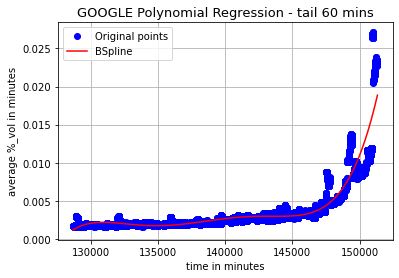

<Figure size 2160x1440 with 0 Axes>

In [104]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

y_i = new_data.values[128700:151318]
x_i = np.linspace(128700, 151318, 22618)
t, c, k = interpolate.splrep(x_i, y_i, s=3, k=5)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x_i.min(), x_i.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x_i, y_i, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.title("GOOGLE Polynomial Regression - tail 60 mins", fontsize=13)
plt.xlabel("time in minutes")
plt.ylabel("average %_vol in minutes")
plt.figure(figsize = (30,20))
plt.show()

t: [ 1.  1.  1.  1.  1. 60. 60. 60. 60. 60.]
c: [0.00602418 0.00233937 0.00426663 0.0018095  0.0026097  0.
 0.         0.         0.         0.        ]
k: 4



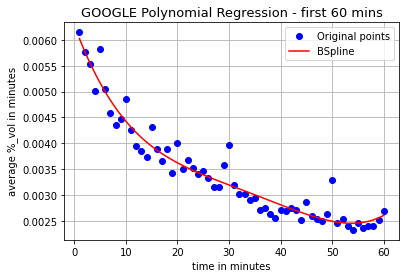

In [ ]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

y = np.asarray(df['avrg'][1:61]) 
x = np.asarray(df['row_num'][1:61])

t, c, k = interpolate.splrep(x, y, s=2, k=4)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.title("GOOGLE Polynomial Regression - first 60 mins", fontsize=13)
plt.xlabel("time in minutes")
plt.ylabel("average %_vol in minutes")
plt.show()

In [ ]:
def mean_squared_error(y, x):
    return np.mean((y - x)**2)
    

In [ ]:
testing_MSE = mean_squared_error(y, spline(x))
testing_MSE

7.209698685043364e-37

t: [330. 330. 330. 330. 330. 330. 389. 389. 389. 389. 389. 389.]
c: [ 0.00137145  0.00586194 -0.00967283  0.02060307 -0.01460675  0.01746533
  0.          0.          0.          0.          0.          0.        ]
k: 5



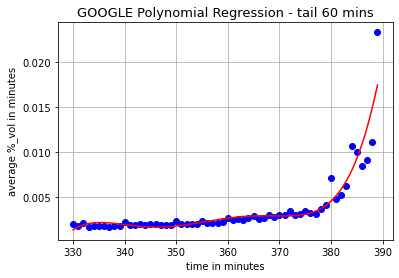

In [ ]:
y_tail = np.asarray(df['avrg'][-61:-1])
x_tail = np.asarray(df['row_num'][-61:-1])

t, c, k = interpolate.splrep(x_tail, y_tail, s=3, k=5)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x_tail.min(), x_tail.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x_tail, y_tail, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
plt.grid()
plt.title("GOOGLE Polynomial Regression - tail 60 mins", fontsize=13)
plt.xlabel("time in minutes")
plt.ylabel("average %_vol in minutes")
plt.show()

In [ ]:
testing_MSE = mean_squared_error(y_tail, spline(x_tail))
testing_MSE

1.4579687384163018e-06